In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('CartPole-v1')
render = lambda: plt.imshow(env.render(mode='rgb_array'))
env.reset()

array([ 0.03545609, -0.02184595,  0.02987738, -0.01873233])

c:\ProgramData\Anaconda3\envs\torchpy37\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] 스레드 모드가 설정된 후에는 바꿀 수 없습니다
  warnings.warn(str(err))


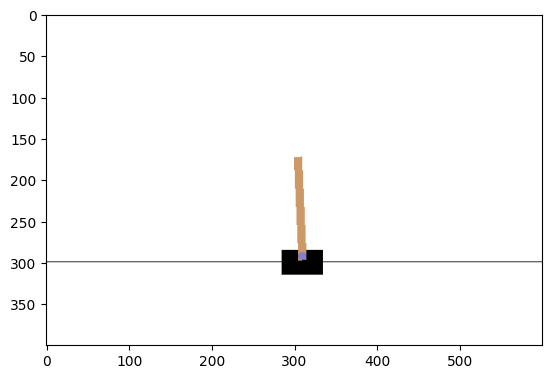

In [3]:
for i in range(10):
    env.step(env.action_space.sample())
    render()

In [4]:
env.close()

In [5]:
env = gym.make('CartPole-v1')
print(env.observation_space.shape[0])
print(env.action_space)

4
Discrete(2)


In [6]:
import gym
import numpy as np
# import plotly.express as px
import tensorflow as tf

import copy
import pylab
import random

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [7]:
# class REINFORCE(tf.keras.model.Model)
# tf.keras.model 내의 Model API가 부모클래스임을 선언하고 있음.

class REINFORCE(tf.keras.models.Model):
    
    # REINFORCE 클래스의 구성요소를 정의
    def __init__(self, action_size, **kwargs):
        super().__init__(**kwargs)
        self.fc1 = Dense(24, activation='relu')
        self.fc2 = Dense(24, activation='relu')
        self.fc_out = Dense(action_size, activation='softmax')
    
    # def call()로 구체적인 모형을 정의함.
    # REINFORCE가 호출될 때 call(self, x)의 x가 입력됨.
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        policy = self.fc_out(x)
        return policy

In [8]:
# REINFORCE를 학습시키기 위한 5개의 함수로 구성된 클래스

class REINFORCEAgent:
    
    # def __init__()
    # REINFORCEAgent의 변수, 초모수, 속성을 정의
    def __init__(self, state_size, action_size):
        # 상태의 크기
        self.state_size = state_size
        
        # 행동의 크기
        self.action_size = action_size
        
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        
        self.model = REINFORCE(self.action_size)
        self.optimizer = Adam(lr=self.learning_rate)
        self.states = []
        self.actions = []
        self.rewards = []
    
    # def get_action()
    # state를 정책 딥러닝에 입력하고 action 분포를 출력으로 받은 후, 이 분포에 따라 선택한 action을 반환하는 함수
    # 여기에서 주의해야 할 것은, 정책 딥러닝의 출력은 2D Tensor 실수이므로 self.model(state)[0]으로 지정해야 0D 텐서 실수가 됨.
    def get_action(self, state):
        policy = self.model(state)[0] # 생략하면 2D
        policy = np.array(policy)
        return np.random.choice(self.action_size, 1, p=policy)[0] # 생략하면 1D
    
    # def discount_rewards()
    # discount factor를 이용하여 R(t)를 계산
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    # def append_sample()
    # 1 episode에서 생성된 (state, action, reward)를 저장하고 있으며 action을 one-hot 벡터로 변환하고 있음.
    def append_sample(self, state, action, reward):
        self.states.append(state[0])
        self.rewards.append(reward)
        act = np.zeros(self.action_size)
        act[action] = 1
        self.actions.append(act)
    
    # def train_model()
    # REINFORCE 클래스로 정의된 정책 딥러닝을 학습시키는 함수
    def train_model(self):
        discounted_rewards = np.float32(self.discount_rewards(self.rewards))
        
        # 정규화
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)
        
        model_params = self.model.trainable_variables
        
        with tf.GradientTape() as tape:
            tape.watch(model_params)
            policies = self.model(np.array(self.states))
            actions = np.array(self.actions)
            action_prob = tf.reduce_sum(actions * policies, axis=1)
            cross_entropy = -tf.math.log(action_prob + 1e-5)
            loss = tf.reduce_sum(cross_entropy * discounted_rewards)
        
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))
        self.states = []
        self.actions = []
        self.rewards = []

In [10]:
# Episode = 1000개를 생성하고 매 Episode마다 모수를 Update하고 있음.
env = gym.make('CartPole-v1')

# get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = REINFORCEAgent(state_size, action_size)

scores = []
episodes = []
episode_score = []

EPISODES = 1000

for e in range(EPISODES):
    done = False
    score = 0
    
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        
        agent.append_sample(state, action, reward)
        score += reward
        
        state = next_state
        
        if done:
            agent.train_model()
            print('Episode:', e, 'Score:', score)
            episode_score.append([e, score])
            scores.append(score)
            episodes.append(e)

Episode: 0 Score: 33.0
Episode: 1 Score: 9.0
Episode: 2 Score: 13.0
Episode: 3 Score: 11.0
Episode: 4 Score: 27.0
Episode: 5 Score: 11.0
Episode: 6 Score: 17.0
Episode: 7 Score: 16.0
Episode: 8 Score: 16.0
Episode: 9 Score: 10.0
Episode: 10 Score: 17.0
Episode: 11 Score: 9.0
Episode: 12 Score: 12.0
Episode: 13 Score: 15.0
Episode: 14 Score: 20.0
Episode: 15 Score: 22.0
Episode: 16 Score: 11.0
Episode: 17 Score: 10.0
Episode: 18 Score: 30.0
Episode: 19 Score: 23.0
Episode: 20 Score: 30.0
Episode: 21 Score: 37.0
Episode: 22 Score: 35.0
Episode: 23 Score: 19.0
Episode: 24 Score: 18.0
Episode: 25 Score: 9.0
Episode: 26 Score: 14.0
Episode: 27 Score: 15.0
Episode: 28 Score: 15.0
Episode: 29 Score: 28.0
Episode: 30 Score: 16.0
Episode: 31 Score: 8.0
Episode: 32 Score: 27.0
Episode: 33 Score: 16.0
Episode: 34 Score: 19.0
Episode: 35 Score: 10.0
Episode: 36 Score: 31.0
Episode: 37 Score: 10.0
Episode: 38 Score: 17.0
Episode: 39 Score: 17.0
Episode: 40 Score: 13.0
Episode: 41 Score: 12.0
Episod

In [11]:
import pandas as pd
df = pd.DataFrame(episode_score, columns=['episode', 'return'])
df

,episode,return
0,0,33.0
1,1,9.0
2,2,13.0
3,3,11.0
4,4,27.0
...,...,...
995,995,500.0
996,996,500.0
997,997,500.0
998,998,500.0


In [12]:
print(df.shape)

(1000, 2)


In [20]:
print(df['return'].values)

[ 33.   9.  13.  11.  27.  11.  17.  16.  16.  10.  17.   9.  12.  15.
  20.  22.  11.  10.  30.  23.  30.  37.  35.  19.  18.   9.  14.  15.
  15.  28.  16.   8.  27.  16.  19.  10.  31.  10.  17.  17.  13.  12.
  17.  25.  13.  18.  19.  33.  11.  15.  11.  19.  21.  28.  30.  13.
  26.  15.  30.  15.  43.  19.  17.  36.  32.  13.  10.  37.  10.  43.
  20.  18.  10.  29.  33.  85.  23.  16.  43.  10.  30.  16.  21.  40.
   9.  13.  25.  16.  16.  15.  13.  52.  13.  43.  12.  25.  11.  16.
  20.  31.  20.  19.  56.  25.  24.  32.  12.  27.  55.  13.  12.  26.
  22.  12.  33.  35.  12.  57.  15.  32.  19.  18.  18.  12.  18.  26.
  17.  28.  14.  11.  15.  35.   8.  13.  19.  49.  19.  43.  56.  33.
  24.  92.  57.  38.  17. 102.  10.  34.  66.  37.  13.  15.  18.  24.
  74.  11.  69.  22.  19.  22.  28.  54.  16.  77.  20.  34.  25.  22.
  10.  37.  12.  42.  31.  22.  13.  44.  27.  12.  16.  46.  50.  20.
  56.  42.  67.  39.  21.  23.  66.  11.  81.  20.  23.  23.  51.  34.
  16. 

In [22]:
print(len(df['return'].values))
print(np.min(df['return'].values))
print(np.mean(df['return'].values))
print(np.max(df['return'].values))

1000
8.0
287.103
500.0


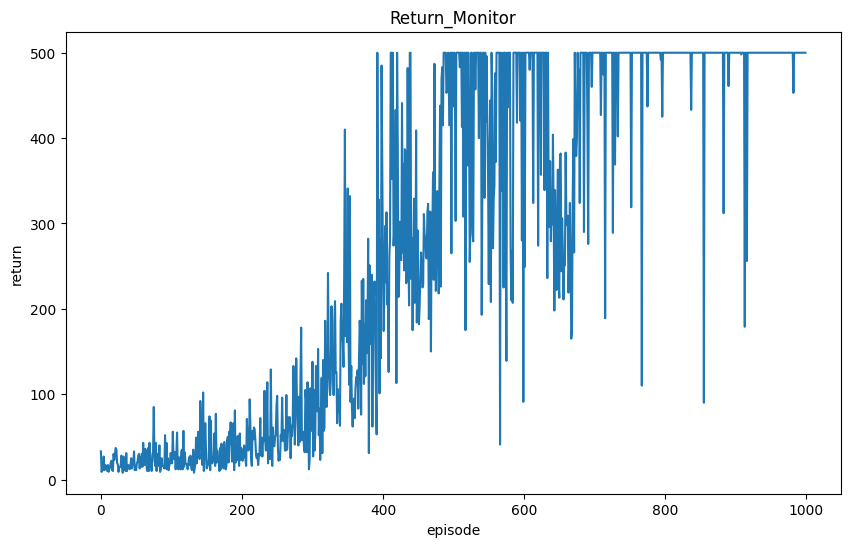

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
plt.plot(df['episode'], df['return'])
plt.xlabel('episode')
plt.ylabel('return')
plt.title('Return_Monitor')
plt.show()